In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,MinMaxScaler,FunctionTransformer,OneHotEncoder
from sklearn.pipeline import make_pipeline,Pipeline
from sklearn.compose import ColumnTransformer,make_column_selector


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn import svm

from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_auc_score
from imblearn.over_sampling import SMOTE


from sklearn.linear_model import RidgeClassifier,RidgeClassifierCV,LogisticRegressionCV
from xgboost import XGBClassifier

In [2]:
train_data = pd.read_csv('train.csv',index_col='id')
test_data = pd.read_csv('test.csv',index_col='id')
sample_data = pd.read_csv('sample_submission.csv')
original_data = pd.read_csv('original.csv')

train_data_copy = train_data.copy()

In [3]:
# train_data[train_data['YearsAtCompany']>40]
# train_data[train_data['TotalWorkingYears']>40]
# train_data[train_data['JobLevel'] >5]

In [4]:
# train_data.drop(train_data[train_data['JobLevel'] >5].index,axis=0,inplace=True)
# train_data.drop(train_data[].index,axis=0,inplace=True)
# train_data.drop(train_data[train_data['YearsAtCompany']>40].index,axis=0,inplace=True)
# train_data.drop(train_data[train_data.Education == 15].index,axis=0,inplace=True)


# index = train_data[train_data['JobLevel'] >5index
# train_data.loc[index,'JobLevel'] = 5

# index = train_data[train_data['TotalWorkingYears']>40].index
# train_data.loc[index,'TotalWorkingYears'] = 40
                  
# index = train_data[train_data['YearsAtCompany']>40].index
# train_data.loc[index,'YearsAtCompany'] = 40

# index = train_data[train_data.Education == 15].index
# train_data.loc[index,'Education'] = 5

In [5]:
original_data_copy = original_data.copy()
original_data_copy['Attrition'] = np.where(original_data_copy['Attrition'] == 'Yes',1,0)
original_data_copy.drop(['EmployeeNumber'],axis=1,inplace=True)

# positives = original_data_copy[original_data_copy['Attrition'] == 1]

# train_data = pd.concat([train_data,positives])
train_data = pd.concat([train_data,original_data_copy])

In [6]:
train_data.drop(['EmployeeCount','StandardHours','Over18'],axis=1,inplace=True)
test_data.drop(['EmployeeCount','StandardHours','Over18'],axis=1,inplace=True)

In [7]:
# index = train_data[(train_data['EducationField'] == 'Other')&(train_data['JobRole'] == 'Sales Representative')].index
# train_data.drop(index,axis=0,inplace=True)

In [8]:
def create_features(data):
    df = data.copy()
    df['BusinessTravel'] = np.select([df['BusinessTravel'] == 'Non-Travel', 
                                          df['BusinessTravel'] == 'Travel_Rarely',
                                          df['BusinessTravel'] == 'Travel_Frequently'],
                                         [1,2,3]
                                        )
    # ['Education','JobRole']
    # df['education_jobrole'] = df['EducationField'] + df['JobRole']
    alpha = .000001
    int_col = df.select_dtypes(include = np.number).columns
    df[int_col] = df[int_col] + alpha
    df['income_joblevel'] = df['JobLevel'] / df['MonthlyIncome'] 
    df['progress'] = df['YearsAtCompany']  / df['YearsInCurrentRole'] 
    df['Age'] = pd.cut(df.Age,bins=3,labels=[1,2,3]).astype(int)
    # df['Age'] = pd.cut(df.Age,bins=2,labels=[1,2]).astype(int)
    
    df['avg_earn'] = df.groupby(['Education','Age'])['MonthlyIncome'].transform('mean')
    df['earn_sat'] = (df.MonthlyIncome / df.HourlyRate ) - df['avg_earn'] 
    # df.drop(['avg_earn'],axis=1,inplace=True)

    df['balance'] = df.WorkLifeBalance / df.RelationshipSatisfaction
    df['comfort'] = df['balance'] * df['BusinessTravel']
    # df['over_time_distance'] = df['DistanceFromHome'] / df['OverTime'] 
    df['comfort_2'] =  ((df['balance'] * (df['JobSatisfaction']) / df['EnvironmentSatisfaction']))
    # df['comfort_3'] = (df['comfort'] * df['Age'])/  df['overTime']
    
    
    df['fairness_1']  = (df['JobInvolvement'] / df['JobLevel']) * (df['PercentSalaryHike'] / df['PerformanceRating']) 
    df['fairness_2']  =   df['YearsSinceLastPromotion'] /(df['YearsAtCompany'] * df['JobSatisfaction']) 
    df['fairness_3']  =  (df['TotalWorkingYears'] / (df['YearsAtCompany']) * df['JobSatisfaction']) 
    df['fairness'] = ((df['fairness_1'] + df['fairness_2'] + df['fairness_3'])/3) * df['StockOptionLevel'] * df['BusinessTravel']
    # df['fairness_'] = ((df['fairness_1'] + df['fairness_2'] + df['fairness_3'])/3) / (df['StockOptionLevel'] * df['BusinessTravel'] / df['Age'] )
    
    
    int_col = df.select_dtypes(include = np.number).columns
    df[int_col] = df[int_col] - alpha
    df.drop(['balance','avg_earn','EducationField','JobRole'],axis=1,inplace=True)

    return df

In [9]:
train_data[train_data['JobLevel'] >5]

,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,HourlyRate,...,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition
1535,30,Travel_Rarely,583,Research & Development,6,3,Life Sciences,4,Female,100,...,4,0,12,1,2,8,7,1,5,0


In [10]:
train_data.shape

(3147, 31)

In [11]:
train_data_x = create_features(train_data.drop('Attrition',axis=1))
test_data = create_features(test_data)

print(train_data_x.shape,test_data.shape)
train_data_x['Attrition'] = train_data['Attrition']

train_data = train_data_x

(3147, 37) (1119, 37)


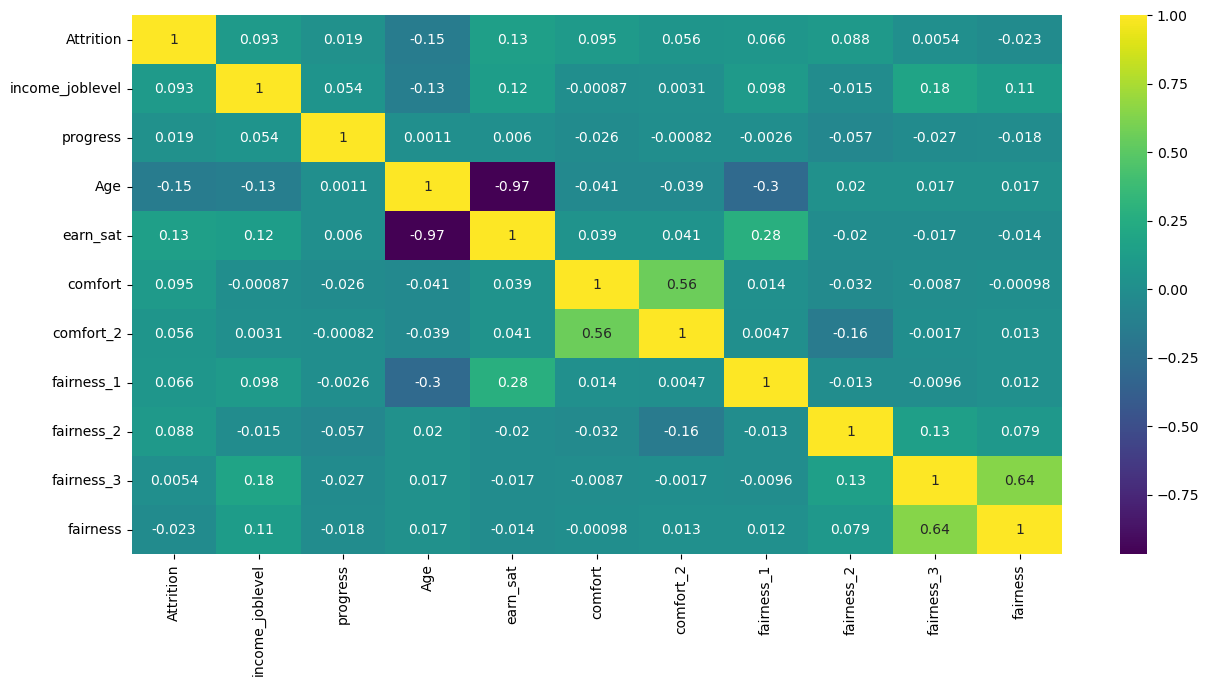

In [12]:
data = train_data[['Attrition','income_joblevel','progress','Age',
                   'earn_sat','comfort','comfort_2','fairness_1',
                    'fairness_2','fairness_3','fairness',
                       # 'fairness_'
                   # 'comfort_3',
                  ]]

plt.figure(figsize=(15,7));
sns.heatmap(data.corr(),annot=True,cmap='viridis');

In [13]:
train_data.shape

(3147, 38)

In [14]:
train_data["Attrition"].value_counts()

0    2710
1     437
Name: Attrition, dtype: int64

In [15]:
# train_data.nunique()

In [16]:
# train_data[(train_data['EducationField'] == 'Other')&(train_data['JobRole'] == 'Sales Representative')]

In [17]:
index = train_data[train_data['JobLevel'] >5].index
# train_data.loc[index,'JobLevel'] = 5
train_data.loc[index]


,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,...,income_joblevel,progress,earn_sat,comfort,comfort_2,fairness_1,fairness_2,fairness_3,fairness,Attrition
1535,0.999999,2.0,583.0,Research & Development,6.0,3.0,4.0,Female,100.0,3.0,...,0.001313,1.142856,-4008.735913,1.0,0.374999,1.857142,0.041666,4.5,0.000003,0


In [18]:
index = train_data[train_data['TotalWorkingYears']>40].index
# train_data.loc[index,'TotalWorkingYears'] = 40
train_data.iloc[index]

,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,...,income_joblevel,progress,earn_sat,comfort,comfort_2,fairness_1,fairness_2,fairness_3,fairness,Attrition
877,1.999999,2.0,682.0,Research & Development,1.0,4.0,4.0,Male,57.0,4.0,...,0.000402,5.124998,-6414.489271,1.5,0.562499,4.888886,0.09756,3.0,5.324306,0


In [19]:
index = train_data[train_data['YearsAtCompany']>40].index
# train_data.loc[index,'YearsAtCompany'] = 40
train_data.iloc[index]

,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,...,income_joblevel,progress,earn_sat,comfort,comfort_2,fairness_1,fairness_2,fairness_3,fairness,Attrition
877,1.999999,2.0,682.0,Research & Development,1.0,4.0,4.0,Male,57.0,4.0,...,0.000402,5.124998,-6414.489271,1.5,0.562499,4.888886,0.09756,3.0,5.324306,0


In [20]:
index = train_data[train_data.Education == 15].index
# train_data.loc[index,'Education'] = 5
train_data.iloc[index]

,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,...,income_joblevel,progress,earn_sat,comfort,comfort_2,fairness_1,fairness_2,fairness_3,fairness,Attrition
527,1.999999,2.0,548.0,Research & Development,1.0,15.0,1.0,Female,72.0,3.0,...,0.000377,2.499998,-2607.27778,5.999998,11.999982,12.999987,0.049999,5.6,12.433344,0


In [21]:
# index = train_data[train_data['JobLevel'] >5].index
# train_data.drop(index,axis=0,inplace=True)

# index = train_data[train_data['TotalWorkingYears']>40].index
# train_data.drop(index,axis=0,inplace=True)

# index = train_data[train_data['YearsAtCompany']>40].index
# train_data.drop(index,axis=0,inplace=True)

# index = train_data[train_data.Education == 15].index
# train_data.drop(index,axis=0,inplace=True)

In [22]:
index = train_data[train_data['JobLevel'] >5].index
train_data.loc[index,'JobLevel'] = 5

index = train_data[train_data['TotalWorkingYears']>40].index
train_data.loc[index,'TotalWorkingYears'] = 40

index = train_data[train_data['YearsAtCompany']>40].index
train_data.loc[index,'YearsAtCompany'] = 40

index = train_data[train_data.Education == 15].index
train_data.loc[index,'Education'] = 5



In [23]:
# index = train_data[train_data.Education == 15].index
# train_data.loc[index,'Education'] = 5

In [24]:
# index = test_data[train_data.Education == 15].index
# train_data.loc[index,'Education'] = 5


In [25]:
train_data = pd.get_dummies(train_data)
test_data = pd.get_dummies(test_data)
print(train_data.shape,test_data.shape)
print(set(train_data.columns) - set(test_data.columns))
smote = SMOTE(random_state=0)
train_data,train_label = smote.fit_resample(train_data.drop('Attrition',axis=1),train_data['Attrition'])

train_data['Attrition'] = train_label

(3147, 44) (1119, 43)
{'Attrition'}


In [26]:
strat_train_set, strat_test_set = train_test_split(
    train_data, test_size=0.3, stratify=train_data["Attrition"], random_state=42)

train_features = strat_train_set.drop('Attrition',axis=1)
train_label = strat_train_set.Attrition

test_features = strat_test_set.drop('Attrition',axis=1)
test_label = strat_test_set.Attrition

In [27]:
# strat_train_set, strat_test_set = train_test_split(
#     train_data, test_size=0.3, stratify=train_data["PerformanceRating"], random_state=42)

# train_features = strat_train_set.drop('Attrition',axis=1)
# train_label = strat_train_set.Attrition

# test_features = strat_test_set.drop('Attrition',axis=1)
# test_label = strat_test_set.Attrition

In [28]:
# scaler = StandardScaler()
# train_features = scaler.fit_transform(train_features)
# test_features = scaler.transform(test_features)

In [29]:
# model = RidgeClassifier()
# model  = LogisticRegressionCV()
# model  = RidgeClassifierCV()
model  = XGBClassifier()
model.fit(train_features,train_label)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

C:\Users\EMEKA ONWUEPE\anaconda3\envs\homl3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


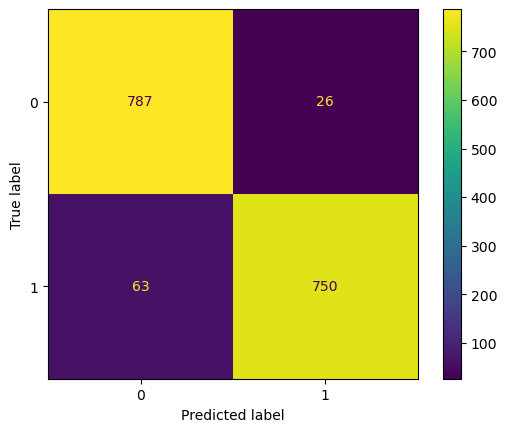

In [30]:
plot_confusion_matrix(model,test_features,test_label)
# 787 26
# 61 752

In [31]:
roc_auc_score(test_label, model.predict_proba(test_features)[:, 1])
# 0.9787167070217918

# 9853094471904129

# 0.9848434646708091

0.9836255558127537

In [32]:
# roc_auc_score(test_label, model.decision_function(test_features))

In [33]:
ids = test_data.index 
print(train_data.shape,test_data.shape)

(5420, 44) (1119, 43)


In [34]:


# train_data_ = scaler.fit_transform(train_data.drop('Attrition',axis=1))
# test_data = scaler.transform(test_data)

# model.fit(train_data_,train_data['Attrition'])

In [35]:
model.fit(train_data.drop('Attrition',axis=1),train_data['Attrition'])

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [36]:
predict_prob =  model.predict_proba(test_data)[:, 1]

In [37]:
predict_prob

array([0.09187178, 0.00604574, 0.01728456, ..., 0.01398376, 0.00515912,
       0.00045806], dtype=float32)

In [38]:
prediction = model.predict(test_data)

In [39]:
prediction.sum()

# 103
# 110
# 100

100

In [40]:
prediction.shape

(1119,)

In [41]:
prediction.size - prediction.sum()

1019

In [42]:
data = {"id":ids,'Attrition':predict_prob}

submission = pd.DataFrame(data)

In [43]:
submission

,id,Attrition
0,1677,0.091872
1,1678,0.006046
2,1679,0.017285
3,1680,0.007265
4,1681,0.059561
...,...,...
1114,2791,0.050423
1115,2792,0.001552
1116,2793,0.013984
1117,2794,0.005159


In [44]:
submission.to_csv('submission.csv',index=False)